In [1]:
###
#  FUTON Model MDP + Q-Learning Creation Script
#  A Research Project conducted by Noah Dunn 
###

# Import the standard tools for working with Pandas dataframe
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import shelve
import random
import math
import time
import ctypes
# Pickle provides easy Object Serialization for quick read + writes of data
import pickle
# Vector Quantization for Determining Cluster Centers
from scipy.cluster.vq import vq
# Skikit offers a solution to perform K-Means++ clustering
from sklearn.cluster import KMeans
# Scipy provides a library to execute Z-Score Normalization
from scipy.stats import zscore
# We want to do type hinting for API clarification
from typing import *
# Import the MDP toolbox that contains a method for conducting Q-Learning
# Tool can be found here: https://github.com/sawcordwell/pymdptoolbox
# Documentation for the tool can be found here 
import mdptoolbox
# Itertools provides an easy way to perform Cartesian product on multiple sets
from itertools import product as cartesian_prod
import multiprocessing


### Some repetitive type hinting
int_matrix2D = np.array
float_matrix2D = np.array
int_matrix3D = np.array
float_matrix3D = np.array

In [2]:
#  The Data File that will be used to conduct the experiments
patientdata:pd.DataFrame = pd.read_csv("G:/MIMIC-ALL/MIMIC-PATIENTS/patient_data_modified.csv")

In [3]:
### 
#  An MDP, or Markov Decision Process is used to model relationships between various states and actions.
#  A state can be thought of in medical solution as a patient's diagnosis based on current vitals and state of being. 
#  An action can be thought of as a change in current diagnosis based on one of those vitals.
#  The inspirations for the bulk of this code came from Komorowksi's AI Clinician which can be found 
#  here: https://github.com/matthieukomorowski/AI_Clinician/blob/master/AIClinician_core_160219.m
###

###
# Begin by establishing some global variables for use in the MDP creation
###
mdp_count:int = 500            # The number of repititions we want/count of MDPs we need to create 
clustering_iter:int = 32       # The number of times clustering will be conducted
cluster_sample:float = 0.25    # Proportion of the data used for clustering
gamma:float = 0.99             # How close we desire clusters to be in similarity (Percentage)
transition_threshold:int = 5   # The cutoff value for the transition matrix
final_policies:int = 1         # The number of policies we would like to end up with
state_count:int = 750          # The number of distinct states
action_count:int = 5           # Number of actions per state (reccommended 2 to 10)
crossval_iter:int = 5          # Number of crossvalidation runs (Default is 80% Train, 20% Test)
# This will be replaced by the loop index at some point (Iterations of all the models)
loop_index:int = 0


In [4]:
###
# Data structures to hold our interim data
###

###
# The 30 and 15 constants here are used solely for the purpose of allotting enough space
# to save information later on down in the pipeline
## 
model_data:np.ndarray = np.empty((mdp_count*2, 30,))
model_data[:] = np.nan

bestmodels_data:np.ndarray = []

In [5]:
"""
# The extract_init_column_data function takes 6 arguments: 
# 
# patient_data:   The full DataFrame of all the patient data, raw and unfiltered
# id_column:      The name of the column in the dataframe containing the patient IDs
# binary_columns: A list containing the names of all the columns that are binary data (only 0s and 1s)
# normal_columns: A list containing the names of all the columns that are regular data (require no function transformations)
# log_columns:    A list containing the names of all the columns that are logarithmic data (Log has already been applied)
# debug_flag:     A boolean flag that indicates whether or not print statements will be executed
# 
# The function has 6 return values:
#
# colbin:       The resulting list of binary data columns, or the default list if none is provided
# colnorm:      The resulting list of normal data columns, or the default list if none is provided
# collog:       The resulting list of log data columns, or the default list if none is provided
# MIMIC_raw:    The DataFrame containing the data of all desired columns and their values
# id_count:     The total number of IDs to be used  
# icu_ids:      The ids of all patients to be used
# patient_idxs: 
"""

def extract_init_column_data(patient_data:pd.DataFrame, id_column:str='icustayid', binary_columns:List[str]=None, normal_columns:List[str]=None,
                            log_columns:List[str]=None, debug_flag:bool=False) -> (List[str], List[str], List[str], 
                                                                                   pd.DataFrame, pd.DataFrame, int, List[List[int]]):

    # Grab list of unique patient ICU stay IDs
    icu_ids:int = patient_data[id_column].unique()
    # Number of patients to be used for states
    id_count:int = icu_ids.size
    if debug_flag:
        print(id_count)

    # Create a data structure to save patient data for report
    patient_idxs:List[List[int]]= np.zeros((id_count, mdp_count,), dtype=np.int64)

    # All our columns are broken up into 3 distinct categories:
    # 1. Binary values (0 or 1)
    # 2. Standard Ranges (Plain old Integers + Decimals)
    # 3. Logarthmic Values (columnvalue = log(columnvalue))
    colbin:List[str] = []
    colnorm:List[str] = [] 
    collog:List[str] = []
    
    # Enables custom column selection
    if binary_columns == None:
        colbin = ['gender','mechvent','max_dose_vaso','re_admission', 'qSOFAFlag', 'SOFAFlag']
    else:
        colbin = binary_columns
    
    if normal_columns == None:
        colnorm = ['age','Weight_kg','GCS','HR','SysBP','MeanBP','DiaBP','RR','Temp_C','FiO2_1',
        'Potassium','Sodium','Chloride','Glucose','Magnesium','Calcium',
        'Hb','WBC_count','Platelets_count','PTT','PT','Arterial_pH','paO2','paCO2',
        'Arterial_BE','HCO3','Arterial_lactate','SOFA','SIRS','Shock_Index','PaO2_FiO2','cumulated_balance', 'qSOFA'];
    else:
        colnorm = normal_columns
    if log_columns == None:
        collog = ['SpO2','BUN','Creatinine','SGOT','SGPT','Total_bili','INR','input_total','input_4hourly','output_total','output_4hourly'];
    else:
        collog = log_columns
    # Create seperate dataframes for each of the columns
    colbin_df:pd.DataFrame = patient_data[colbin]
    colnorm_df:pd.DataFrame = patient_data[colnorm]
    collog_df:pd.DataFrame = patient_data[collog]
    
    if debug_flag:
        # Let's make sure we have what we need
        print(colbin_df, "\n", colnorm_df, "\n", collog_df)
    # Rearrange the dataframe in order of binary, normal, and log data from left to right
    MIMIC_raw:pd.DataFrame = pd.concat([colbin_df, colnorm_df, collog_df], axis=1)
    if debug_flag:
        print(MIMIC_raw) 
    return colbin, colnorm, collog, MIMIC_raw, id_count, icu_ids, patient_idxs
    

In [6]:
colbin, colnorm, collog, MIMIC_raw, id_count, icu_ids, patient_idxs = extract_init_column_data(patientdata, debug_flag=False)

In [7]:
"""
# The construct_zscores function takes 4 arguments: 
# 
# colbin:    The list of all columns representing binary values
# colnorm:   The list of all columns representing normal values
# collog:    The list of all columns representing log values
# MIMIC_raw: The DataFrame containing the data of all desired columns and their values
#
# and returns 
# colbin:    The resulting list of binary data columns, or the default list if none is provided
# colnorm:   The resulting list of normal data columns, or the default list if none is provided
# collog:    The resulting list of log data columns, or the default list if none is provided
# MIMIC_raw: The DataFrame containing the data of all desired columns and their values
"""

def construct_zscores(colbin:List[str], colnorm:List[str], collog:List[str], MIMIC_raw:pd.DataFrame) -> pd.DataFrame:

    # We want a Z-Score for every item. This a measure of variance to see how far a value is from the mean

    # We need to normalize binaries to -0.5 and 0.5 for later use
    MIMIC_zscores:pd.DataFrame = MIMIC_raw

    # No need for the zscore algorithm here, -0.5 and 0.5 suffice
    MIMIC_zscores[colbin] = MIMIC_zscores[colbin] - 0.5

    # Recall these columns are logarithmic, so they needed converted back for proper Z-Scoring (+ 0.1 to avoid log(0))
    # Note that log(0.1) is essentially 0, Mathematically proved
    
    # zscore is the function pulled from the stats library in the initial import calls
    MIMIC_zscores[collog] = np.log(MIMIC_zscores[collog] + 0.1).apply(zscore)

    # Normal column requires no modifications. Z-Scores are calculated as normal
    MIMIC_zscores[colnorm] = MIMIC_zscores[colnorm].apply(zscore)
    print(MIMIC_zscores)

    # We want the Re_Admission and fluid intake scaled Similarly to the other variables
    MIMIC_zscores['re_admission'] = np.log(MIMIC_zscores['re_admission'] + 0.6)
    # Apply a scalar to fluid intake
    MIMIC_zscores['input_total'] = 2 * MIMIC_zscores['input_total']
    
    return MIMIC_zscores

In [8]:
MIMIC_zscores:pd.DataFrame = construct_zscores(colbin, colnorm, collog, MIMIC_raw) 

        gender  mechvent  max_dose_vaso  re_admission  qSOFAFlag  SOFAFlag  \
0         -0.5       0.5           -0.5          -0.5        0.5      -0.5   
1         -0.5       0.5           -0.5          -0.5        0.5       0.5   
2         -0.5       0.5           -0.5          -0.5        0.5       0.5   
3         -0.5       0.5           -0.5          -0.5        0.5       0.5   
4         -0.5       0.5           -0.5          -0.5        0.5       0.5   
...        ...       ...            ...           ...        ...       ...   
238325    -0.5      -0.5           -0.5          -0.5        0.5      -0.5   
238326    -0.5      -0.5           -0.5          -0.5        0.5      -0.5   
238327    -0.5      -0.5           -0.5          -0.5        0.5      -0.5   
238328    -0.5      -0.5           -0.5          -0.5        0.5      -0.5   
238329    -0.5      -0.5           -0.5          -0.5        0.5      -0.5   

             age  Weight_kg       GCS        HR  ...       BUN 

In [9]:
"""
# The split_training_and_test function takes 4 arguments: 
# 
# id_count:     Total number of patient IDs to be used
# icu_ids:      The IDs for all ICU visits
# debug_flag:   A flag that enables/disables print statements 
# save_to_file: A flag that saves our deisred
# 
# and returns 3 values:
# 
# train_ids:  The ICU visit IDs to be used in the training set
# test_ids:   The ICU visit IDs to be used in the testing set
# train_flag: A list over all of MIMIC_raw that marks training rows as True
"""

def split_training_and_test(id_count:int, icu_ids:pd.DataFrame, debug_flag:bool, save_to_file:bool) -> (
                                    pd.DataFrame, pd.DataFrame, pd.DataFrame):

    ### The main loop to generate all possible models

    num_rows:int = id_count  # Total Number of Patients to divy data up
    testing_flag:int = 1     # The random number we use to identify a patient used for testing

    # This will allow the loop over a large about of models

    train_ids:List[int] = []       # A list containing all training ids from the icu_ids list
    test_ids:List[int] = []         # A list containing all testing ids from the icu_ids list

    # We want approximate 20% test, 80% train, so we random numbers 1-5
    # 1s Represent data points that will be used to test, 2-5 will be used to train
    group_ids:pd.DataFrame = pd.DataFrame([int(np.floor(crossval_iter * np.random.random() + 1)) for i in range(1, id_count + 1)])
    icu_pair_set:pd.DataFrame = pd.concat([pd.DataFrame(icu_ids), group_ids], axis=1, sort=False)
    icu_pair_set.columns = ['id', 'fil_val']
    train_ids =  icu_pair_set[icu_pair_set['fil_val'] != testing_flag]
    test_ids = icu_pair_set[icu_pair_set['fil_val'] == testing_flag]

    # We want to ensure that the testing patients + training patients = total patients
    if (train_ids['id'].size + test_ids['id'].size) != id_count:
        print("The testing and training set do not add up to the total set")
    
    if debug_flag:
        # Percentage for testing should be about 20%, Training about 80%
        print("Testing Percentage: " + str((test_ids['id'].size / id_count)))
        print("Training Percentage: " + str((train_ids['id'].size / id_count)))

    # After grabbing all the IDs, we want to flag all the rows that are train or test
    train_flag:pd.DataFrame = patientdata['icustayid'].isin(train_ids['id'])
    # Save the training ids for later if we need to use them
    if save_to_file:
        # Temporarily write train_flag for later use DELETE LATER
        with open('sample_train.txt', 'wb') as fp:
            pickle.dump(train_flag, fp)
    return train_ids, test_ids, train_flag

In [10]:
train_ids, test_ids, train_flag = split_training_and_test(id_count, icu_ids, True, True)

Testing Percentage: 0.20253459441830127
Training Percentage: 0.7974654055816988


In [11]:
"""
# The zscores_for_train_and_test function takes 8 arguments: 
# 
# train_flag:       The dataframe representing whether or not a row is used in training or not
# MIMIC_zscores:    The dataframe representing the zscores of the dataset
# debug_flag:       A flag that determines if print statements are executed
# save_flag:        A flag that determines if the training_zscores are saved
# patient_data:     The raw MIMIC dataframe
# bloc_name:        The name of the column that dictates a 'bloc' of time within an ICU visit
# id_name:          The name of the column that dictates an ICU stay's ID
# death_name:       The name of the column that dictates a patient's life status 
# 
# and returns 7 values:
# 
# train_zscores:   The portion of MIMIC_zscores that is in the training set
# test_zscores:    The portion of MIMIC_zscores that is in the testing set
# train_blocs:     The rows of the MIMIC dataset that is in the training set
# test_blocs:      The rows of the MIMIC dataset that is in the testing set
# train_id_list:   The list of all IDs in the training set
# train_90d:       A flag indicating if a given patient died in the training set after 90d
# test_90d:        A flag indicating if a given patient died in the testing set after 90d
"""

def zscores_for_train_and_test(train_flag:pd.DataFrame, MIMIC_zscores:pd.DataFrame, debug_flag:bool, save_flag:bool,
                               patient_data:pd.DataFrame, bloc_name:str, id_name:str, death_name:str) -> (pd.DataFrame,
                               pd.DataFrame, pd.DataFrame, pd.DataFrame, pd.DataFrame, pd.DataFrame, pd.DataFrame, pd.DataFrame, pd.DataFrame):

    # Seperate the Z-Scores for the training set and the testing set
    train_zscores:pd.DataFrame = MIMIC_zscores[train_flag]
    test_zscores:pd.DataFrame = MIMIC_zscores[~train_flag]

    # Validate all data is selected
    if(train_zscores.size + test_zscores.size != MIMIC_zscores.size):
        print("The Z-Scores are all evenly distributed")


    # The blocs of relevance in order based on the train and test set
    # These will be used to build relevant data frames later down
    train_blocs:List[int] = patientdata[train_flag][bloc_name]
    test_blocs:List[int] = patientdata[~train_flag][bloc_name]

    # Doing the same with the patient ids
    train_id_list:pd.DataFrame = patientdata[train_flag][id_name]
    # We modify a column later to use for the test_id_list, not necesssary here.

    # Grabbing the boolean values for the patients who died within 90 days in the training set
    train_90d:pd.DataFrame = patientdata[train_flag][death_name]
    test_90d:pd.DataFrame = patientdata[~train_flag][death_name]
    # Next, we want to sample the existing training set to only pick cluster_sample percent to use
    
    # We want to flag all the data points in the train_zscores set that will be used to create the MDP
    
    # Note: len(train_zscores.index) is the fastest way to get the number of rows in a dataframe in pandas
    
    # The actual set to use
    sample_train_set:pd.DataFrame = train_zscores[train_flag]
        
    if save_flag:
        # Python has object serialization to make write/reads fasters, in the form of pickle
        # Save the important data (clusters created as a result of the K-Means operations)
        # This process takes quite a while. This will provide a checkpoint to decrease compute time
        # until the code is put into dev.
        with open('train_zscores.txt', 'wb') as fp:
            pickle.dump(train_zscores, fp)
        with open('test_zscores.txt', 'wb') as fp:
            pickle.dump(test_zscores, fp)
    return train_zscores, test_zscores, train_blocs, test_blocs, train_id_list, train_90d, test_90d, sample_train_set

In [12]:
train_zscores, test_zscores, train_blocs, test_blocs, train_id_list, train_90d, test_90d, sample_train_set = \
zscores_for_train_and_test(train_flag, MIMIC_zscores, True, True, patientdata, 'bloc', 'icustayid', 'mortality_90d')

G:\anaconda\lib\site-packages\ipykernel_launcher.py:56: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


In [13]:
def calculate_optimal_clusters(data_set:pd.DataFrame, max_state_count:int=750, num_loops_per_iter:int=10000,
                                max_num_iter:int=32):
    # Code for this sample was provided largely by Dr. Giabbanelli 
    # This makes use of the new curvature method for calculating optimal clusters
    # For K-Means sampling
    variance_results:List[float] = np.zeros((max_state_count))
    for state_count in range(1, max_state_count):
        clusters_models = KMeans(n_clusters=state_count, max_iter=num_loops_per_iter, n_init=max_num_iter).fit(data_set)
        cluster_values = clusters_models.cluster_centers_
        closest_clusters:np.ndarray = vq(train_zscores, cluster_values)
        cluster_distances = closest_clusters[1]
        total_variance = 0
        for i in range(0, len(cluster_distances)):
            total_variance = total_variance + cluster_distances[i]
        variance_results[state_count] = total_variance    
        print(f'Finished with {state_count} at a variance of {total_variance}')
    return variance_results

In [14]:
def calculate_optimal_clusters_parallel(num:int):
    data_set=sample_train_set
    max_state_count=state_count
    num_loops_per_iter=10000
    max_num_iter=clustering_iter
    total_needed_runs:List[int] = [i for i in range(1, 751)]
    thread_needed_runs:List[int] = np.array_split(total_needed_runs, 24)[num]
    # Code for this sample was provided largely by Dr. Giabbanelli 
    # This makes use of the new curvature method for calculating optimal clusters
    # For K-Means sampling
    variance_results:List[float] = np.zeros((max_state_count))
    for state_count in thread_needed_runs:
        clusters_models = KMeans(n_clusters=state_count, max_iter=num_loops_per_iter, n_init=max_num_iter).fit(sample_train_set)
        cluster_values = clusters_models.cluster_centers_
        closest_clusters:np.ndarray = vq(train_zscores, cluster_values)
        cluster_distances = closest_clusters[1]
        total_variance = 0
        for i in range(0, len(cluster_distances)):
            total_variance = total_variance + cluster_distances[i]
        variance_results[state_count] = total_variance    
        print(f'Finished with {state_count} at a variance of {total_variance}')
        single_run = f'{state_count},{total_variance}'
        with open('all_cluster_runs.csv', 'a') as f:
            print(single_run, file=f)
            

In [15]:
run_optimal_clusters = False
run_multithread = False
if run_optimal_clusters:
    if run_multithread:     
        pool = multiprocessing.Pool()
        pool.map(calculate_optimal_clusters_parallel, range(23))
    else:
        variance_results = calculate_optimal_clusters(data_set=sample_train_set, max_state_count=state_count, num_loops_per_iter=10000, 
                            max_num_iter=clustering_iter)
        with open('variance_results.txt', 'wb') as fp:
            pickle.dump(variance_results, fp)

In [13]:
"""
# The zscores_for_train_and_test function takes 5 arguments: 
# data_set:               The training dataset used to generate the various clusters
# state_count:            Total number of clusters desired in the end result
# num_loops_per_iter:     The number of loops ran per 1 iteration to approximate clusters
# max_num_iter:           Number of iterations to run the algorithm
# debug_flag:             True indicates print statements are included, False indicates no prints
# regenerate_flag:        True indictates the kmeans will be run again. False means the cached/previous file value will be used
# 
# and returns 4 values:
# 
# cluster_values:         A value generated based on the Z-Scores of all the patient's data relative to each other
# cluster_labels:         A number generated for the correspond state -> value relationship. Range is 0 to state_count
# train_zscores:          The Z-Scores of the training set as created earlier
# closest_clusters:       A list representing which state each patient datapoint is closest to
# 
"""
def kmeans_cluster_calculations(data_set:pd.DataFrame, state_count:int=750, num_loops_per_iter:int=10000,
                                max_num_iter:int=32, debug_flag:bool=True, regenerate_flag=False) -> (List[List[np.float64]], 
                                                                                                      List[int], pd.DataFrame, 
                                                                                                      np.ndarray, np.ndarray):
    # In order to prepare a proper set of states, we want to use k-means clustering to group various patients into 
    # distinct states based on Z-Scores

    # K-Means or K-Means++ is a technique used to condense very diverse and sparse data into similar groups called 'clusters'
    # The K-means algorithm will create k clusters from N data points. In the case of this research,
    # the algorithm divides patients into groups that have similar data (age, blood pressure, etc..) and creates a faux 'point'
    # at the center of that particular clustering of data

    # The KMeans takes three 'settings' arguments
    # 1. n_clusters: The number of clusters (later to be used as states), that we desire the algorithm to produce
    # this value has been preset to state_count which is 750
    # 2. max_iter: How many times each round of k-means clustering will make adjustments, set at 10,000 in my case
    # 3. n_init: The number of max_iter batches that will be conducted in a row. The best of these will be chosen
    # and saved in the variable clusters_models
    if regenerate_flag:
        clusters_models = KMeans(n_clusters=state_count, max_iter=num_loops_per_iter, n_init=max_num_iter).fit(data_set)
        # Save the important data (clusters created as a result of the K-Means operations)
        # This process takes quite a while. This will provide a checkpoint to decrease compute time
        # until the code is put into dev.
        with open('cluster_labels.txt', 'wb') as fp:
            pickle.dump(clusters_models.labels_, fp)
        with open('cluster_centers.txt', 'wb') as fp:
            pickle.dump(clusters_models.cluster_centers_, fp)
        if debug_flag:
            print(clusters_models.labels_)
            print(clusters_models.cluster_centers_)
    

    # Read these values back in from being saved to file
    cluster_values:List[List[np.float64]] = []
    cluster_labels:List[int] = [] 
    train_zscores:pd.DataFrame = []
    test_zscores:pd.DataFrame = []

    with open ('cluster_centers.txt', 'rb') as fp:
        cluster_values = pickle.load(fp)
    with open ('cluster_labels.txt', 'rb') as fp:
        cluster_labels = pickle.load(fp)
    with open ('train_zscores.txt', 'rb') as fp:
        train_zscores = pickle.load(fp)
    with open ('test_zscores.txt', 'rb') as fp:
        test_zscores = pickle.load(fp)
    
    if debug_flag:
        print(cluster_values, "\n", "Dimensions: ", len(cluster_values)," x ", len(cluster_values[0]), "\n", train_zscores)
    
    # We now want to use the clusters to determine their nearest real data point neighbors
    # As a visual of this. Suppose we have 4 flags of different colors scattered over a park. The K-Means++ algorithm
    # is what planted the flags in the middle of groups of people that are similar. The KNN Search (K nearest neighbor search)
    # can be used in MatLab as a simple point finder instead of as a more complicated Supervised Learning algorithm. In Python 
    # we can make use of the Vector Quanization (vq) package to assign each point to a centroid
    
    closest_clusters:np.ndarray = vq(train_zscores, cluster_values)
    closest_clusters_test:np.ndarray = vq(test_zscores, cluster_values)
    

    # Check to make sure each cluster has a value
    print(len(closest_clusters[0]))

    # As an aside, closest_clusters[1] contains the distance between each point's values (in this case 50 of them)
    # and their closest cluster's values.
    # Ex: If a point is [1, 1, 1] and it's closest cluster is the point [3, 3, 3]  closest_clusters[1] would contain the vector
    # [abs(3 - 1), abs(3 - 1), abs(3 - 1)] or [2, 2, 2]

    # Validate that all the points are in the range 0-749 (since there are only 750 clusters as specified previously)
    for i in closest_clusters[0]:
        if(i > (state_count - 1) or i < 0):
            print("The clusters you are searching for are not configured properly and are out of bounds")
            print("Did you modify the cluster_count variable without changing this error configuration?")
    
    return cluster_values, cluster_labels, train_zscores, closest_clusters, closest_clusters_test

In [14]:
cluster_values, cluster_labels, train_zscores, closest_clusters, closest_clusters_test = \
kmeans_cluster_calculations(data_set=sample_train_set, state_count=state_count, num_loops_per_iter=10000, 
                            max_num_iter=clustering_iter, debug_flag=True, regenerate_flag=False)

[[-1.55737705e-01  4.34426230e-01 -3.85754098e-01 ...  3.80228529e-01
   7.31333868e-01  7.12742180e-01]
 [ 3.15217391e-01  1.30434783e-01 -4.71336957e-01 ... -1.47334846e-01
   8.37547692e-01  5.49701284e-01]
 [ 6.93889390e-18 -2.75000000e-01 -4.95625000e-01 ... -6.38592514e-01
  -1.32594951e+00 -1.24390028e+00]
 ...
 [-4.90196078e-02 -3.23529412e-01 -4.90843137e-01 ... -2.94132415e-01
   3.32300837e-01  4.33748198e-01]
 [-6.09756098e-02 -4.51219512e-01 -5.00000000e-01 ... -1.49388817e+00
  -2.31206609e+00 -1.85290276e+00]
 [ 6.66666667e-02 -4.50000000e-01 -4.98866667e-01 ... -1.18806659e+00
  -3.76091639e-01 -1.59309354e+00]] 
 Dimensions:  750  x  50 
         gender  mechvent  max_dose_vaso  re_admission  qSOFAFlag  SOFAFlag  \
0         -0.5       0.5          -0.50     -2.302585        0.5      -0.5   
1         -0.5       0.5          -0.50     -2.302585        0.5       0.5   
2         -0.5       0.5          -0.50     -2.302585        0.5       0.5   
3         -0.5       0.5

In [42]:
def optimize_cluster_number(cluster_distances):
    total_variance = 0
    for i in range(0, len(cluster_distances)):
        total_variance = total_variance + cluster_distances[i]
    return total_variance
    
    

In [43]:
print(closest_clusters[1])

[3.64203943 3.37064619 3.34727037 ... 4.23057997 6.60645421 4.86979698]


In [44]:
print(len(cluster_values))

750


In [45]:
print(cluster_labels)

[387 387 469 ... 294 228 228]


In [47]:
print(optimize_cluster_number(closest_clusters[1]))

867011.5382800455


In [22]:
"""
# The generate_action_column function takes 4 arguments: 
#
# column_values: A series of column values from a dataframe that we want to turn into action states
# num_groups: How many groups or distinct actions we want to split the data into
# column_name: The name of the column used for print debug statements
# num_rows: The total number of rows in the full column before modifications (This is normally patientdata[column_name].size)
# 
# This function returns column_actions, a series that represents the 'action', or group that each row of data falls under.
#
# An example is found down below, but in words, this function takes a full column of data, groups 
# the values for that data into num_groups distinct actions, and returns a series representing actions based on row
# 
# Ex: Patients' blood pressure might be grouped into 5 categories (Action 1: < 20 mmHg, Action 2: > 20 mmHg && < 60 mmHg... etc)
"""

def generate_action_column(column_values:pd.DataFrame, num_groups:int, column_name:str, num_rows:int, debug_flag:bool=True) -> pd.Series:
    # Determine minimum and maxium to scale data appropriately
    if debug_flag:
        print("Old Lowest ", column_name, " Rank: ", min(column_values.rank()))
        print("Old Highest " , column_name,  " Rank: ", max(column_values.rank()))
    # Now we want to rank these actions in order of their value (lowest to highest)
    # Normalizing according to lowest and highest rank
    
    # Moving the minimum to zero
    column_ranks:pd.Series = (column_values.rank() - min(column_values.rank()))
    # Shifting the max to approximately 1.0
    column_ranks:pd.Series = column_ranks / max(column_ranks)
    
    if debug_flag:
        # Validate that the range is indeed 0 to 1
        print("New Lowest ", column_name, " Rank: ", min(column_ranks))
        print("New Highest ", column_name, " Rank: ", max(column_ranks))

    # The Max of all column values needs to be nearly 1, and the min of all column
    # values needs to be nearly 0 
    if round(max(column_ranks), 3) != 1 or round(min(column_ranks), 3) != 0:
        print("The ranks are not normalized correctly, either the max is too high, or the minium is too low")
        print("Current max: ", round(max(column_ranks), 3))
        print("Curret min: ", round(min(column_ranks), 3))
    # Normalize the rank values to even intevals of ranks
    old_values:List[float] = np.sort(column_ranks.unique()).tolist()
    even_intervals:List[float] = [i/column_ranks.unique().size for i in range(0, column_ranks.unique().size)]
    # Iterate over the Series to apply the normalized values
    for i in range(0, column_ranks.size):
        old_value_index:float = old_values.index(column_ranks[i])
        column_ranks[i] = even_intervals[old_value_index] 
    
    # This is a mathematics trick to seperate all the values into {num_groups} distinct groups based on their rank.
    # Given different columns of interest this can take different forms. For IV fluids, this number is 5.
    column_groups:pd.Series = np.floor(((column_ranks + 1.0/float(num_groups)) * (num_groups - 1))) + 1
    
    # Validate that groups are all associated with desired group split
    if not(column_groups.isin([i for i in range(1, num_groups + 1)]).any()):
        print("Groups chosen fall outside the desired 1-" + num_groups + " window")

    column_actions:pd.Series = pd.Series([1 for i in range(0, num_rows)])

    # If the value was non-zero and grouped in the 1 - 4 groups, we grab its value to save as an action
    for index in column_groups.index:
        column_actions[index] = column_groups[index]
        
    return column_actions
    

In [23]:
"""
# This function takes two arguments:
# actions_column: A column of action groups generated by the above function (generate_action_column())
# real_values: The actual values from the dataset corresponding to the same column as actions_column
# and returns a list that contains the real median values for each 'group' actions.
#
# Ex: We apply the function to the action_column "IV_Fluid", which has split the data into 4 different groups of 
# IV_Fluid actions. This function will produce a list containing the median amount of IV_Fluid administered for each of those
# groups (Group 1 -> Adminster 20 mL, Group 2 -> Administer 40 mL, Group 3 -> Administer 60 mL, Group 4 -> Administer 80 mL
"""

def median_action_values(actions_column: pd.DataFrame, real_values:pd.DataFrame) -> List[np.float64]:
    # Grab all the unique actions for a column and sort them
    all_groups:List[np.float64] = np.sort(actions_column.unique())
    # Concatanate the group number and real value for each row
    action_set:pd.DataFrame = pd.concat([actions_column, real_values], axis=1, sort=False)
    # Name the columns for accurate querying
    action_set.columns = ['group_id', 'data_val']
    # Grab the median value for each group based on group number using python list comprehension
    median_values:List[np.float64] = [np.median(action_set[action_set['group_id'] == i]['data_val']) for i in all_groups]
    return median_values


In [24]:
""" 
# This function takes one argument
# list_action_columns: This is a Pandas dataframe that contains all the action_columns we desir to be grouped by index
# This can be retrieving using the previously defined 'median action' function 
# 
# and returns two items:
# list_action columns: The 'keys' or integers that represent every permutation of actions
# chosen_action: The key that was chosen based on the action values in each column
"""
def generate_action_matrix(list_action_columns:pd.DataFrame) -> (List[int], List[int]):
    # Grabs the list of columns the user has provided for use
    desired_columns:List[str] = [column for column in list_action_columns]
    # Drops all group combinations that are duplicates
    list_action_columns_indexes:pd.DataFrame = list_action_columns.drop_duplicates(desired_columns)
    # Sorts all combinations in order
    list_action_columns_indexes = list_action_columns_indexes.sort_values(desired_columns)
    # Create a dictionary based on the values from the dataframe 
    list_action_columns_indexes:List[int] = list_action_columns_indexes.values.tolist() 
    # Determine which index in the list each row corresponds to 
    # Ex: For an 2-D action permutation list of [1,1] thru [5,5], there are 5 x 5 possibilities
    # {1..5}, {1..5}, so there are 25 possible permutations, the indexes will run 1 - 25
    chosen_action:List[int] = [list_action_columns_indexes.index(val_pair) for val_pair in list_action_columns.values.tolist()]
    # Return the keys first, and then the true values for the dataset
    return list_action_columns_indexes, chosen_action
    

In [25]:
"""
# The build_dataset_actions function takes 7 arguments: 
# patientdata: A Dataframe representing all the patients and their data
# first_column: Our first column that we desire to build our action matrix with (first_column x second_column) (SOFA by default)
# second_column: Our second column that we desire to build or action matrix with (first_column x second_column) (qSOFA by default)
# num_groups_first_column: The number of groups we want to divide our first column into (5 by default)
# num_groups_second_column: The number of groups we want to divide our second column into (4 by default)
# debug_flag: A boolean that determines whether we want debug prints presents
# graph_flag: Whether we want to print the graph or not
# 
# and returns 2 values:
# 
# train_chosen_actions:        The actions for each row of the training dataset
# train_action_values:         The matrix representing (first_column x second_column)
# action_list:                 A list of actions taken at every given datapoint
"""
def build_dataset_actions(patientdata:pd.DataFrame, first_column:str="SOFA", second_column:str="qSOFA", num_groups_first_column:int=5,
                         num_groups_second_column:int=4, debug_flag:bool=True, graph_flag:bool=True) -> (pd.Series, 
                                                                                                         List[List[int]],
                                                                                                         List[int]):
    # Generate the actions for a the first desired column of data
    first_col:pd.DataFrame = patientdata[first_column]
    first_col_actions:pd.Series = generate_action_column(column_values = first_col, num_groups = num_groups_first_column, 
                                                        column_name = first_column, 
                                                         num_rows = patientdata[first_column].size, debug_flag=True)
    if debug_flag:
        print(first_col_actions.unique())    
    # Now do the same for the second desired column of data
    second_col:pd.DataFrame = patientdata[second_column]
    second_col_actions:pd.Series = generate_action_column(column_values = second_col, num_groups = num_groups_second_column,  
                                                         column_name = second_column, 
                                                         num_rows = patientdata[second_column].size, debug_flag=True)
    if debug_flag:
        print(second_col_actions.unique())
    
    # Obtain the median real values that each division represents
    first_median_actions:List[np.float64] = median_action_values(actions_column = first_col_actions, real_values = patientdata[first_column])
    second_median_actions:List[np.float64] = median_action_values(actions_column = second_col_actions, real_values = patientdata[second_column])
    
    if debug_flag:
        print(first_column," Action Median Values:", str(first_col_actions), "\n" + second_column + ":", second_median_actions, "\n")
    ###
    # FINISH CONSTRUCTION OF ALL ACTIONS AND THEIR VALUES
    ###
    # Combine the columns that we desire to observe (iv_fluid_actions, vasopressor_actions)
    combined_groups:pd.DataFrame = pd.concat([first_col_actions, second_col_actions], axis=1, sort=False)
    # Name the columns for proper usage in the function
    combined_groups.columns = [first_column, second_column]
    
    # The Key value pair for every datapoint and the corresponding action taken at that point
    action_keys, action_list = generate_action_matrix(list_action_columns = combined_groups)
    # Plot the distribution of actions
    if graph_flag:
        plt.hist(action_list, density=False, bins=20)  # `density=False` would make counts
        plt.ylabel("Count")
        plt.xlabel("Index of Action Chosen: 1 through 24")
    train_chosen_actions:List[np.float64] = []
    with open ('sample_train.txt', 'rb') as fp:
        train_chosen_actions = pickle.load(fp)
    test_chosen_actions:List[bool] = [not i for i in train_chosen_actions]
    # Grab a Series representing the action taken by the train data only
    train_chosen_actions:pd.Series = pd.Series(action_list)[train_chosen_actions]
    # Grab a Series representing the action taken by the test data only
    test_chosen_actions:pd.Series = pd.Series(action_list)[test_chosen_actions]

    # Assign all action choices to their corresponding median values as shown previously
    if debug_flag:
        print(first_median_actions, second_median_actions)


    # This gives us the representative median values for a patient's vitals present in various action groups
    # action_keys[i] corresponds to train_action_values[i]
    # So, if the patient falls into group [1, 1] or no iv fluid given, no vasopressor administered,
    # The corresponding median values for this group will be represented by train_action_values (0.0, 0.0).
    # A patient in group [1, 2] (no iv fluid, a little vasopressor) will have a median real value of (0.0, 0.04)
    action_values_matrix:List[List[int]] = list(cartesian_prod(first_median_actions, second_median_actions))

    if len(action_values_matrix) != len(first_median_actions) * len(second_median_actions):
        print("Something went wrong in determining the Cartesian product")
    
    return train_chosen_actions, test_chosen_actions, action_values_matrix, action_list
    


Old Lowest  SOFA  Rank:  2962.5
Old Highest  SOFA  Rank:  238328.0
New Lowest  SOFA  Rank:  0.0
New Highest  SOFA  Rank:  1.0
[2 3 1 4 5]
Old Lowest  qSOFA  Rank:  30048.0
Old Highest  qSOFA  Rank:  235188.0
New Lowest  qSOFA  Rank:  0.0
New Highest  qSOFA  Rank:  1.0
[3 2 1 4]
SOFA  Action Median Values: 0         2
1         2
2         2
3         2
4         2
         ..
238325    1
238326    1
238327    2
238328    1
238329    1
Length: 238330, dtype: int64 
qSOFA: [0.0, 1.0, 2.0, 3.0] 

[1.0, 5.0, 9.0, 15.0, 20.0] [0.0, 1.0, 2.0, 3.0]


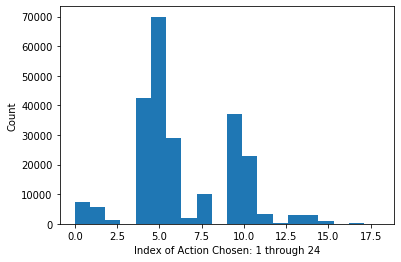

In [26]:
train_chosen_actions, test_chosen_actions, action_values_matrix, action_list = build_dataset_actions(patientdata=patientdata, 
                      first_column="SOFA", second_column="qSOFA", 
                      num_groups_first_column=5, num_groups_second_column=4, 
                      debug_flag=True, graph_flag=True)

In [27]:
"""
# The construct_prestate_matrix_train function takes 5 arguments: 
# train_90d:              A column representing whether or not a patient was dead or alive at the end of 90days
# train_blocs:            All the rows of data for a patient for each individual hospital stay
# closest_clusters:       The closest data cluster that a given data point falls near
# train_chosen_actions:   The action that is represented by two of the patient's characteristics, calculated previously
# is_debug:               Whether or not statements are printed over time.
# 
# and returns 1 value:
# 
# qlearning_dataset_mod: The full training dataset configured to be converted into states and actions
# all_lower_ranges:      The lower bound for the reward values
# all_upper_ranges:      The upper bound for the reward values
"""
def construct_prestate_matrix_train(train_90d:pd.DataFrame, train_blocs:pd.DataFrame, closest_clusters:List[List[int]],
                                    train_chosen_actions:pd.DataFrame, is_debug:bool = True, action_count:int = 20, 
                                    state_count:int = 750) -> (pd.DataFrame, List[int], List[int]):
    ###
    # BEGIN CONSTRUCTION OF PRE-STATE MATRIX
    # This will be used to build the full state/action matrix
    ### 

    # Based on whether or not a patient is dead, we establish the range of possible values:
    # If they have died, the range is [-100, 100]
    # If they are alive, the range is [100, -100]
    range_vals:List[int] = [100, -100]
    # Convert the range of values for a patient's status (dead or alive) from 0 or 1 to -1 or 1
    # This will enable ranges to suit the above criteria [-100, 100] or [100, -100]
    train_90d_polarity:List[int] = (2 * (1 - train_90d) - 1)
    range_matrix:List[int] = [np.multiply(polarity, range_vals) for polarity in train_90d_polarity]
    # Grab the lower range limit and upper range limit seperately in order to build the
    # full range of reward values
    all_lower_ranges:List[int] = [i[0] for i in range_matrix]
    all_upper_ranges:List[int] = [i[1] for i in range_matrix]
        
    # The qlearning_dataset prior to modification contains 6 columns and ~190885 rows (around 75% of the data)
    # The columns are as follows:
    #
    # training_bloc: time_series stamps for a patient's state over time, very in range from {1..?}
    #
    # closest_cluster_index: The index of the nearest cluster to the z-scores of the patient's data, 
    # corresponding actual data for each cluster's index (i) can be found in cluster_values[i]
    #
    # chosen_action_index: The chosen action or representation of a patient's IV_Fluid and Vasopressor status [0 - 24]
    # 
    # 90d_mortality_status: 0 means the patient is alive 90 days after discharge from ICU
    #                      1 means the patient is dead  90 days after discharge from ICU
    #
    # lower_range + upper_range: An index to be used later on, gathered from the range index
    print("Training Blocs Length: ", str(len(train_blocs)), "\nClosest Clusters Length: ", str(len(closest_clusters[0])), 
          "\nAction List Length: ", str(len(train_chosen_actions)), "\nTrain 90d Length", str(len(train_90d)), 
          "\nRange Matrix Length: ", len(range_matrix))
    qlearning_dataset:pd.DataFrame = pd.concat([pd.Series(train_blocs.tolist()), 
                                   pd.Series(closest_clusters[0]), 
                                   pd.Series(train_chosen_actions.tolist()), 
                                   pd.Series(all_lower_ranges),
                                   pd.Series(train_90d.tolist())], 
                                   axis=1, sort=False)
    qlearning_dataset.columns = ['training_bloc', 'closest_cluster_index', 'chosen_action_index', 'reward_value', '90d_mortality_status']
    if is_debug: 
        print(qlearning_dataset)
    
    # Modify the set for the final time in order to construct the final life + death states for each patient
    qlearning_dataset_mod = modify_qlearning_dataset(ql_dataset = qlearning_dataset)# Print some important details of the set
    if is_debug:
        # Total patients being observed in the test
        print(len(qlearning_dataset_mod[qlearning_dataset_mod['training_bloc'] == 1]['training_bloc']))
        # Show that we now have end states established 
        print(len(qlearning_dataset[qlearning_dataset['chosen_action_index'] == action_count]['chosen_action_index']))
        print(len(qlearning_dataset_mod[qlearning_dataset_mod['chosen_action_index'] == action_count]['chosen_action_index']))
        print(len(qlearning_dataset_mod[qlearning_dataset_mod['closest_cluster_index'] == state_count]['chosen_action_index']))
        print(len(qlearning_dataset_mod[qlearning_dataset_mod['closest_cluster_index'] ==  state_count + 1]['chosen_action_index']))
        print(qlearning_dataset_mod, "\n")
    return qlearning_dataset_mod, all_lower_ranges, all_upper_ranges
    

In [28]:
"""
# modify_qlearning_dataset is a function that takes a dataframe intended for qlearning and modifies
# it in preparation for the ML. In essence, it runs through creating the life and and death states in preparation
# for constructing the MDP
#
# Parameters: 
# ql_dataset:  The Dataset we want to modify in preparation
# is_training: Whether we are building the training set or not.
# is_debug:    Whether prints are included or not
#       
# 
# Returns: qlearning_dataset_mod - The modified dataset
"""

def modify_qlearning_dataset(ql_dataset:pd.DataFrame) -> pd.DataFrame:
    # The base qlearning_dataset does not account for endpoints in either life or death
    # These states have not been established yet, which is what this step corrects
    qlearning_dataset:pd.DataFrame = ql_dataset.copy()
    qlearning_dataset_len:int = len(qlearning_dataset.index)
    # We need space to add a death/life state for every patient, about a 20% increase in size from the original MDP
    # We will cut the excess off by the end of the loop
    qlearning_dataset_len_mod:float = int(np.floor(qlearning_dataset_len * 1.2))
    qlearning_dataset_mod:np.ndarray = []
    qlearning_dataset_mod:np.ndarray = np.array([[0 for i in range(0, 5)] for i in range(0, qlearning_dataset_len_mod)])
    # Start construction of modified data
    row:int = 0
    # In Markov theory, an absorbing state is one which can be entered, but cannot be left. (Similar to the Hotel California)
    # In the case of this experiment, those states are either life (state_count) or death (state_count + 1) per patient as
    # defined by me (750, 751)
    absorbing_states:List[int] = [state_count, state_count + 1]

    # Start the loop to begin capping the markov chain off at life and death states
    for i in range(0, qlearning_dataset_len - 1):
        # Use the already gathered data for each row
        qlearning_dataset_mod[row, :] = qlearning_dataset.iloc[i][0:5]
        # If we arrive at the terminal point (end of patient data), we need to point the MDP to either the death or life state
        if qlearning_dataset.iloc[i + 1]['training_bloc'] <= qlearning_dataset.iloc[i]['training_bloc']:
            # Grab the row
            whole_row:pd.DataFrame = qlearning_dataset.iloc[i]
            # Set most of the row to the original data's values, except set the action to be either state 750 or 751
            # Life or death respectively
            row = row + 1
            # We need bloc number, final state (life or death, 750 or 751), end action (-1), and the reward value (lower_range)
            qlearning_dataset_mod[row, :] = [whole_row['training_bloc'] + 1, absorbing_states[whole_row['90d_mortality_status']], -1,  whole_row['reward_value'], whole_row['90d_mortality_status']]
        row = row + 1
    # Add in the last row
    whole_row:pd.DataFrame = qlearning_dataset.iloc[len(qlearning_dataset.index) - 1]
    qlearning_dataset_mod[row, :] = [whole_row['training_bloc'] + 1, absorbing_states[whole_row['90d_mortality_status']], -1,  whole_row['reward_value'], whole_row['90d_mortality_status']]
    
    row = row + 1
    # Get rid of the unneeded rows
    qlearning_dataset_mod:pd.DataFrame = pd.DataFrame(qlearning_dataset_mod[0:row, :])
    qlearning_dataset_mod.columns = ['training_bloc', 'closest_cluster_index', 'chosen_action_index', 'reward_value', 'death_state']
    # Set all rows not in the terminal states to 0 reward to start
    qlearning_dataset_mod.loc[qlearning_dataset_mod['chosen_action_index'] != -1,'reward_value'] = 0
    return qlearning_dataset_mod

In [29]:
qlearning_dataset_train_final, all_upper_ranges, all_lower_ranges = construct_prestate_matrix_train(train_90d = train_90d, 
                                                                                            train_blocs = train_blocs, 
                                                                                            closest_clusters = closest_clusters,
                                                                                            train_chosen_actions = train_chosen_actions, 
                                                                                            is_debug=True,
                                                                                            action_count=action_count, 
                                                                                            state_count=state_count)

Training Blocs Length:  189793 
Closest Clusters Length:  189793 
Action List Length:  189793 
Train 90d Length 189793 
Range Matrix Length:  189793
        training_bloc  closest_cluster_index  chosen_action_index  \
0                   1                    521                    8   
1                   2                    387                    4   
2                   3                    387                    9   
3                   4                    387                    5   
4                   5                    387                   10   
...               ...                    ...                  ...   
189788              9                    572                    0   
189789             10                    372                    1   
189790             11                    716                    4   
189791             12                    572                    0   
189792             13                    572                    0   

        reward_value  

In [30]:
###
#  Now that we officially have some a valid bloc for actions, and a valid set of states, it's time 
#  to begin building the transitions matrix.
###

### If the matrix is bidirectional (S1 -> S2, S2 -> S1 are both valid, we can build two matrices)

### 
# The MDP Toolbox we are going to be using requires Transition and Reward Matrices to be in the form
# M(action, state1, state2)
###

"""
# The create_transition_matrix method takes 4 arguments:
# num_actions: The total number of possible actions (calculated by action_count ^ 2 or in py, action_count ** 2)
# num_states:  Number of states the model uses
# qlearning_dataset: The dataset that will be used for the qlearning process
# transition_threshold: How many actions do we want to deem as scarce and not worth keeping (default = 5)
# reverse: If false, the matrix that is created is represented as transition[A][S1][S2], if true: transition[A][S2][S1]
# 
# and returns 2 values:
# transition_matrix: The counts of which actions were chosen in which states
# physician_policy:  The transition_matrix that has been turned into probabilties by dividing counts in each state by 
# total counts
# 
"""
def create_transition_matrix(num_actions:int, num_states:int, ql_data_input:pd.DataFrame, 
                             transition_threshold:int = 5, reverse:bool = False) -> (int_matrix2D, float_matrix2D):
    # The transition matrix is a 3D construct, involving a transition between two states
    # and an action. The dimensions for the matrix are (state_count * 2) * (state_count + 2) * action_count
    transition_matrix:float_matrix2D = [[[0 for i in range(0, num_states + 2)] for i in range(0, num_states + 2)] for i in range(0, num_actions)]
    # NP Arrays allow for more compact and efficient slicing
    transition_matrix = np.array(transition_matrix).astype(float)
    # We also need a matrix to denote the policy that corresponds with taken a particular action from a state
    transition_policy_count:int_matrix2D = [[0 for i in range(0, num_states + 2 )] for i in range(0, num_actions)]
    transition_policy_count = np.array(transition_policy_count).astype(float)
    # Iterate over the actual data in order to form the actual states and their corresponding actions
    # As soon as we hit the next patient (the next row has a training bloc value of 1), we stop processing actions for that patient
    for i in range(0, len(ql_data_input) - 1):
        # Since 1 is our 'endpoint' for each patient, there are no actions we can take from this point on
        if ql_data_input.iloc[i + 1]['training_bloc'] > ql_data_input.iloc[i]['training_bloc']:
            S1:int = ql_data_input.iloc[i]['closest_cluster_index']
            S2:int = ql_data_input.iloc[i + 1]['closest_cluster_index'] 
            action_id:int = ql_data_input.iloc[i]['chosen_action_index']
            if not(reverse):
                # Count the number of times S1 -> S2 is taken using action A
                transition_matrix[action_id][S1][S2] = transition_matrix[action_id][S1][S2] + 1
            else:
                # Count the number of times S1 -> S2 is taken using action A
                transition_matrix[action_id][S2][S1] = transition_matrix[action_id][S2][S1] + 1
                
            # Count the number of times action A is used to transition from S1
            transition_policy_count[action_id][S1] = transition_policy_count[action_id][S1] + 1        

    # In order to avoid drastically altering our model, we fix a constant
    # value (set by default to 5), in order to declare sparse actions 
    # as essentially not happening (make their count 0)
    for i in range(0, num_actions):
        for j in range(0, num_states + 2):
            if transition_policy_count[i][j] <= transition_threshold:
                transition_policy_count[i][j] = 0 
    # Now, we want to prevent transitions from state -> state using
    # a certain action if that action is sparse or nonexistant
    for i in range(0, num_actions):
        for j in range(0, num_states + 2):
            if not(reverse):
                # Declare the weight of an unachievable action to have a zero probability
                if transition_policy_count[i][j] == 0:
                    transition_matrix[i,j,:] = 0
                    # All probabilities must be declared, even unreachable states, an easy work around 
                    # to this issue is to simply declare the same state to have a probability of 1
                    # https://stackoverflow.com/questions/43665797/must-a-transition-matrix-from-a-markov-decision-process-be-stochastic
                    transition_matrix[i,j,j] = 1
                # This weights the MDP based on the probability of taking one action from a state
                # As opposed to taking any other possible action from that state
                # S1 -> S2 might be 50%, S1 -> S3 20%, and S1 -> S4 30%
                else:
                    transition_matrix[i,j,:] = transition_matrix[i,j,:]/np.float64(transition_policy_count[i][j])
            else:
                # Declare the weight of an unachievable action to have a zero probability
                if transition_policy_count[i][j] == 0:
                    transition_matrix[i,:,j] = 0
                    # All probabilities must be declared, even unreachable states, an easy work around 
                    # to this issue is to simply declare the same state to have a probability of 1
                    # https://stackoverflow.com/questions/43665797/must-a-transition-matrix-from-a-markov-decision-process-be-stochastic
                    transition_matrix[i,j,j] = 1
                # This weights the MDP based on the probability of taking one action from a state
                # As opposed to taking any other possible action from that state
                # S1 -> S2 might be 50%, S1 -> S3 20%, and S1 -> S4 30%
                else:
                    transition_matrix[i,:,j] = transition_matrix[i,:,j]/np.float64(transition_policy_count[i][j])
    
    # Ensure no divisions create NaNs or infinities
    transition_matrix = np.nan_to_num(transition_matrix)
    # Determine the phyisican's policy based on total count
    # This comes in handy later when comparing model ability
    total_transitions:float = sum(transition_policy_count)
    physician_policy:float_matrix2D = np.divide(transition_policy_count, total_transitions)
    return transition_matrix, physician_policy

In [31]:
# Constructing Transition Matrix(A, State1, State2)
total_actions:int = len(action_values_matrix)     
# Execute the function call
transition_mat, physician_policy = create_transition_matrix(num_actions = total_actions, num_states = state_count,ql_data_input = qlearning_dataset_train_final, transition_threshold = transition_threshold, reverse = False)
# Should be 25, 752, 752
print(len(transition_mat), len(transition_mat[0]), len(transition_mat[0][0]))

20 752 752


G:\anaconda\lib\site-packages\ipykernel_launcher.py:98: RuntimeWarning: invalid value encountered in true_divide


In [32]:
"""
# offpolicy_Q_learning_eval is a method that takes 6 arguments and returns 2 items
# This method evaluates the performance of the MDP determined previously
# 
# Parameters:
# ql_train_set_Q: The actual dataset that serves as our proto-MDP
# phys_pol: A 2D (actions X states) matrix that shows what the phyisican chose according dataset probabilities
# gamma: A hyperparameter for determining how much we value previous data
# alpha: A hyperparameter that weights our reward function at each step
# numtraces: Number of Q-Learning iterations we would like to perform
# num_actions: Total number of actions in the set (For Sepsis: 25)
# num_clusters: Total number of states in the set (For Sepsis: 752)
# is_training:  If False, this is the first phase (construction of the model). If True, the model is being Trained
# 
# Returns:
# Q_Equation = The set of Q-Values obtained by the algorithm's performance
# sum_Q_values = The Q-Equation's performance at a given step in the algorithm
"""
def offpolicy_Q_learning_eval(ql_train_set_Q: pd.DataFrame, death_answer_key:List[int],gamma: float, alpha: float, 
                              numtraces: int, num_actions: int, 
                              num_clusters: int, stopping_difference: float, 
                              is_training=False, is_random=False,
                              modulus_val:int=5000) -> (float_matrix2D, List[float]):
    # We need to save the Q-value for each run 
    sum_Q_values:List[float] = np.zeros((numtraces))
    # Where the Q-Values are saved at each given run
    Q_Equation:int_matrix2D = np.zeros((num_actions, num_clusters))
    # We need to save the Average Q value after so many iterations
    previous_avg_Q:int = 0
    # The list of all starting patient states 
    first_index_list:List[int] = ql_train_set_Q[ql_train_set_Q['training_bloc'] == 1].index
    # A seperate index running in parallel with i for the sum_Q_values
    jj:int = 0
    # If we don't want a random data set from the existant set, only do each data point once
    if not(is_random):
        numtraces = len(first_index_list)
    # We iterate for the total number of times we want to do this process
    for i in range(0, numtraces):
        # Select a random patient starting point from the data
        patient_starter_index:int = 0
        if is_random:
            patient_starter_index:int = random.choice(first_index_list)
        else:
            patient_start_index = first_index_list[i]
        # As Q-learning progreses, we need a data structure to track progress
        full_trace:List[Tuple[float, int, int]] = []
        # While we are still working on a single patient
        num_ql_rows = len(ql_train_set_Q.index)
        # We run until we hit the end of the patient or the end of the dataset
        while patient_starter_index + 1 < num_ql_rows and ql_train_set_Q.iloc[patient_starter_index + 1]['training_bloc'] != 1:
            # Grab state (Initial State at this point)
            state_index:int = ql_train_set_Q.iloc[patient_starter_index + 1]['closest_cluster_index']
            # Grab action taken from this point
            action_index:int = ql_train_set_Q.iloc[patient_starter_index + 1]['chosen_action_index']
            # Grab reward provided by taken an action from this state to the next
            reward_value:float = ql_train_set_Q.iloc[patient_starter_index + 1]['reward_value']
            # A 'step' in the trace, a single data point snapshot
            trace_step:Tuple[float, int, int] = (reward_value, state_index, action_index)
            # Add the step to the full trace
            full_trace.append(trace_step)
            # Increment the current data row
            patient_starter_index = patient_starter_index + 1
        # Full length of the trace path
        trace_length:int = len(full_trace)
        return_reward:float = ql_train_set_Q.iloc[patient_starter_index]['reward_value']
        # Grab the final reward (final reward for last state)
        if is_training:
            # If the model guessed correctly and the patient died, weight the path -100 
            if (reward_value <= 0 and answer_key['death_state'].iloc[patient_starter_index] == 1):
                return_reward = -100
            # If the model guessed correctly and the patient lived, weight the path +100
            elif (reward_value > 0 and answer_key['death_state'].iloc[patient_starter_index] == 0):
                return_reward = 100
            # If the model guessed incorrectly and the patient lived, weight the path +100
            elif (reward_value <= 0 and answer_key['death_state'].iloc[patient_starter_index] == 0):
                return_reward = 100
            # If the model guessed incorrectly and the patient died, weight the path -100
            else:
                return_reward = -100
        # Walk the trace stack backwards
        for j in range(trace_length - 2, -1, -1):
            # Grab the state, action, and reward at each step
            step_state:int = full_trace[j][1]
            step_action:int = full_trace[j][2]
            # Using alpha blending (where we take a portion of the old value and blend it with the new)
            # We blend part of the old value of this state with the new value
            Q_Equation[step_action, step_state] = (1 - alpha) * Q_Equation[step_action, step_state] + alpha * return_reward
            # Recall we have a gamma value to determine the impact of previous decisions on future ones
            # Note: this is a Hyperparameter (a parameter on the model itself)
            return_reward = return_reward * gamma  + full_trace[j][0]
        # Save the overall value based on the current states and actions avaiable at the 
        # current iteration
        sum_Q_values[jj] = np.sum(Q_Equation)
        jj = jj + 1
        # If we haven't hit our max iterations, we still want to see if we should keep pushing forward
        # If there is no noticable progress, we want to stop
        
        # This is only applicable if we are not using all the training data set patients
        if is_random:
            # Perform a check every modulus_val runs
            if i % modulus_val == 0:
                # Grab the current slice of unchecked {modulus_val} values
                slice_mean:float = np.mean(sum_Q_values[j - modulus_val:j])
                # Calculate the difference between current and last average 
                max_difference:float =(slice_mean - previous_avg_Q)/previous_avg_Q
                # Check if the average of this {modulus_val} values is less than 0.001 away from the previous
                if abs(max_difference) < stopping_difference:
                    break
                previous_avg_Q = slice_mean
            
    # Trim off the portion of the list we did not use
    sum_Q_values = sum_Q_values[0:jj]
    return Q_Equation, sum_Q_values

In [33]:
# Grab all the true death states for the patients 
# Once we modify the states during training, we need to see if our predicitions are correct
print(qlearning_dataset_train_final)
answer_key=qlearning_dataset_train_final[qlearning_dataset_train_final['training_bloc'] == 1]
print(answer_key)

        training_bloc  closest_cluster_index  chosen_action_index  \
0                   1                    521                    8   
1                   2                    387                    4   
2                   3                    387                    9   
3                   4                    387                    5   
4                   5                    387                   10   
...               ...                    ...                  ...   
206899              9                    572                    0   
206900             10                    372                    1   
206901             11                    716                    4   
206902             12                    572                    0   
206903             14                    750                   -1   

        reward_value  death_state  
0                  0            0  
1                  0            0  
2                  0            0  
3                  0       

In [34]:
# Normal value for iter_ql is 6, iter_wis is 750
# Q-Learning results is usually a positive value
# WIS Value should be Negative


Q_Equation, sum_Q_values = offpolicy_Q_learning_eval(
        ql_train_set_Q=qlearning_dataset_train_final,
        death_answer_key=answer_key,
        gamma=0.99, 
        alpha=0.1,
        numtraces=30000,
        num_actions=total_actions,
        num_clusters=state_count,
        stopping_difference=0.001,
        is_training=True,
        is_random=False,
        modulus_val=5000
        )

In [35]:
print(qlearning_dataset_train_final)

        training_bloc  closest_cluster_index  chosen_action_index  \
0                   1                    521                    8   
1                   2                    387                    4   
2                   3                    387                    9   
3                   4                    387                    5   
4                   5                    387                   10   
...               ...                    ...                  ...   
206899              9                    572                    0   
206900             10                    372                    1   
206901             11                    716                    4   
206902             12                    572                    0   
206903             14                    750                   -1   

        reward_value  death_state  
0                  0            0  
1                  0            0  
2                  0            0  
3                  0       

In [36]:
"""

"""
def construct_trained_model(ql_final_dataset:pd.DataFrame, state_count:int, 
                            total_actions:int, weighted_probabilities:bool, 
                            physician_policy:List[List[float]]) -> pd.DataFrame:
    # Make a final duplicate of the data
    qlearning_train_final:pd.DataFrame = ql_final_dataset.copy()
    
    # If weights are considered, use the weighted rewards from the Q_Equation, otherwise 
    # use the Q_Equation as is 
    if weighted_probabilities:
        # Weight Q-Value rewards according to their frequency of occuring
        # The Q-Equation for a given state + action pair is equivalent to the reward value
        # The Phyiscian Policy is the probability of that action ocurring given a state
        # These weights prevent rare events from having massively scewed rewards
        # For example, a path that occurs through a given state exactly once would have a much larger
        # reward than a frequently traveled path, which could scew the data.
        value_matrix = np.zeros((state_count, total_actions))
        for i in range(0, state_count):
            for j in range(0, total_actions):
                value_matrix[i][j] = physician_policy[j][i] * Q_Equation[j][i]
        for i in range(0, len(qlearning_train_final.index)):
            row = qlearning_train_final.iloc[i]
            if((row['closest_cluster_index'] != state_count) and (row['closest_cluster_index'] != state_count + 1)):
                row['reward_value'] = value_matrix[row['closest_cluster_index']][row['chosen_action_index']]
    else:
        for i in range(0, len(qlearning_train_final.index)):
            row = qlearning_train_final.iloc[i]
            if((row['closest_cluster_index'] != state_count) and (row['closest_cluster_index'] != state_count + 1)):
                row['reward_value'] = Q_Equation[row['chosen_action_index']][row['closest_cluster_index']]
    
    return qlearning_train_final
        

In [37]:
print(qlearning_dataset_train_final)

        training_bloc  closest_cluster_index  chosen_action_index  \
0                   1                    521                    8   
1                   2                    387                    4   
2                   3                    387                    9   
3                   4                    387                    5   
4                   5                    387                   10   
...               ...                    ...                  ...   
206899              9                    572                    0   
206900             10                    372                    1   
206901             11                    716                    4   
206902             12                    572                    0   
206903             14                    750                   -1   

        reward_value  death_state  
0                  0            0  
1                  0            0  
2                  0            0  
3                  0       

In [38]:
qlearning_train_final = construct_trained_model(ql_final_dataset=qlearning_dataset_train_final, 
                                                state_count=state_count, total_actions=total_actions, 
                                                weighted_probabilities=True, physician_policy=physician_policy)

In [39]:
print(qlearning_dataset_train_final)

        training_bloc  closest_cluster_index  chosen_action_index  \
0                   1                    521                    8   
1                   2                    387                    4   
2                   3                    387                    9   
3                   4                    387                    5   
4                   5                    387                   10   
...               ...                    ...                  ...   
206899              9                    572                    0   
206900             10                    372                    1   
206901             11                    716                    4   
206902             12                    572                    0   
206903             14                    750                   -1   

        reward_value  death_state  
0                  0            0  
1                  0            0  
2                  0            0  
3                  0       

In [40]:
print(qlearning_train_final)

        training_bloc  closest_cluster_index  chosen_action_index  \
0                   1                    521                    8   
1                   2                    387                    4   
2                   3                    387                    9   
3                   4                    387                    5   
4                   5                    387                   10   
...               ...                    ...                  ...   
206899              9                    572                    0   
206900             10                    372                    1   
206901             11                    716                    4   
206902             12                    572                    0   
206903             14                    750                   -1   

        reward_value  death_state  
0                  0            0  
1                 33            0  
2                 17            0  
3                 28       

In [41]:
qlearning_train_final_no_weighting = construct_trained_model(ql_final_dataset=qlearning_dataset_train_final, 
                                                state_count=state_count, total_actions=total_actions, 
                                                weighted_probabilities=False, physician_policy=physician_policy)

In [57]:
def evaluate_model_accuracy(qlearning_train_final:pd.DataFrame):
    # Iterate until the full set is done
    i:int = 0
    total_patients = 0
    correct_guesses = 0
    ql_dataframe_size = len(qlearning_train_final.index)
    while i < ql_dataframe_size:
        total_q_value = 0
        while (i < ql_dataframe_size - 1) and (qlearning_train_final.iloc[i + 1]['chosen_action_index'] != -1):
            total_q_value = total_q_value + qlearning_train_final.iloc[i + 1]['reward_value']
            i = i + 1
        # If we guess correctly, add one to correct guesses
        if ((total_q_value > 0 and qlearning_train_final.iloc[i]['death_state'] == 0) or \
             total_q_value <= 0 and qlearning_train_final.iloc[i]['death_state'] == 1):
                correct_guesses = correct_guesses + 1
        total_patients = total_patients + 1
        i = i + 1
    print(correct_guesses/total_patients)
    

In [58]:
evaluate_model_accuracy(qlearning_train_final=qlearning_train_final)

0.23841523987611757


In [59]:
evaluate_model_accuracy(qlearning_train_final=qlearning_train_final_no_weighting)

0.23841523987611757


In [60]:
qlearning_dataset_test_final, _, _ = construct_prestate_matrix_train(train_90d = test_90d, 
                                                                     train_blocs = test_blocs, 
                                                                     closest_clusters = closest_clusters_test,
                                                                     train_chosen_actions = test_chosen_actions, 
                                                                     is_debug=True,
                                                                     action_count=action_count, 
                                                                     state_count=state_count)

Training Blocs Length:  48537 
Closest Clusters Length:  48537 
Action List Length:  48537 
Train 90d Length 48537 
Range Matrix Length:  48537
       training_bloc  closest_cluster_index  chosen_action_index  \
0                  1                    369                    6   
1                  2                    610                    5   
2                  3                    610                    5   
3                  4                    425                    5   
4                  5                    502                    6   
...              ...                    ...                  ...   
48532              2                    162                    9   
48533              3                    629                    9   
48534              4                    650                    6   
48535              5                    650                    5   
48536              6                    422                    8   

       reward_value  90d_mortality_stat

In [61]:
qlearning_dataset_test_final_weighted = construct_trained_model(ql_final_dataset=qlearning_dataset_test_final, 
                                                state_count=state_count, total_actions=total_actions, 
                                                weighted_probabilities=True, physician_policy=physician_policy)

In [62]:
qlearning_dataset_test_final_nonweighted = construct_trained_model(ql_final_dataset=qlearning_dataset_test_final, 
                                                state_count=state_count, total_actions=total_actions, 
                                                weighted_probabilities=False, physician_policy=physician_policy)

In [63]:
evaluate_model_accuracy(qlearning_dataset_test_final_weighted)

0.24195772058823528


In [64]:
print(qlearning_dataset_test_final_weighted)

       training_bloc  closest_cluster_index  chosen_action_index  \
0                  1                    369                    6   
1                  2                    610                    5   
2                  3                    610                    5   
3                  4                    425                    5   
4                  5                    502                    6   
...              ...                    ...                  ...   
52882              2                    162                    9   
52883              3                    629                    9   
52884              4                    650                    6   
52885              5                    650                    5   
52886              7                    750                   -1   

       reward_value  death_state  
0                 0            1  
1                 0            1  
2                 0            1  
3                 0            1  
4       

In [65]:
evaluate_model_accuracy(qlearning_dataset_test_final_nonweighted)

0.24195772058823528


In [66]:
print(qlearning_dataset_test_final_nonweighted)

       training_bloc  closest_cluster_index  chosen_action_index  \
0                  1                    369                    6   
1                  2                    610                    5   
2                  3                    610                    5   
3                  4                    425                    5   
4                  5                    502                    6   
...              ...                    ...                  ...   
52882              2                    162                    9   
52883              3                    629                    9   
52884              4                    650                    6   
52885              5                    650                    5   
52886              7                    750                   -1   

       reward_value  death_state  
0                 0            1  
1                 0            1  
2                 0            1  
3                 0            1  
4       

In [50]:
evaluate_model_accuracy(qlearning_dataset_test_final)

1.0
